* Título: Sistema de Control de Emergencias (Talanqueras)
* Autor: Juan Jose Gañan. Estudiante Ingenieria de Software
* Año: Mayo de 2024
* Descripción: Este software utiliza técnicas de procesamiento de audio y
aprendizaje automático para detectar sonidos de emergencia (como ambulancias y camiones de bomberos) y simular la elevación de talanqueras en la ciudad de Medellín.

* Modelo:
    - models/2modelo_entrenado_Audio.pkl: Modelo entrenado con KNN para la predicción de sonidos.

* Licencia: MIT License


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from scipy.stats import skew
from sklearn.metrics import confusion_matrix as CM,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score as ACC
from sklearn.metrics import precision_score as PR
from sklearn.metrics import recall_score as RC
from sklearn.metrics import f1_score as F1
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from google.colab import files
import time

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# Conociendo los audios

(66150,) 22050
Señal original


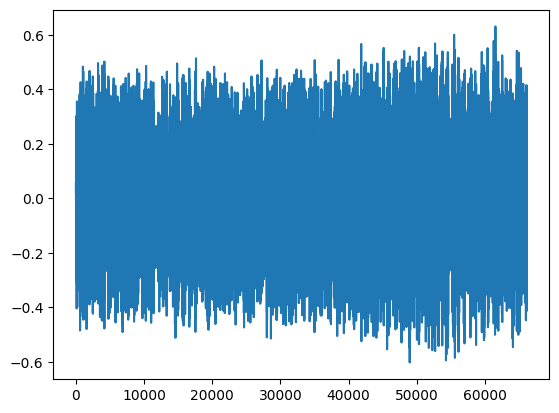

 
Señal muestreada


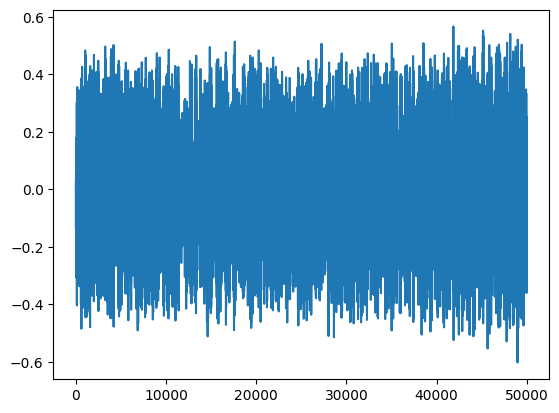

 
(50000,)


In [ ]:
#0. Entendiendo las señales de audio
ruta=r'/content/drive/MyDrive/Semestre 9 (Actual)/ELECTIVA 2 (RECONOCIMIENTO DE PATRONES)/Semana 13 - Reconocimiento de señales de audio/Sonidos/sound_105.wav'
x , sr = librosa.load(ruta)
print(x.shape, sr)
print('Señal original')
plt.plot(x)
plt.show()
print(' ')

X_New = np.resize(x, 50000) #Muestreo
print('Señal muestreada')
plt.plot(X_New)
plt.show()
print(' ')

print(X_New.shape)

In [ ]:
#Extracción de características
Varianza = np.var(X_New)
print(Varianza) #1 dato

Desviacion=np.std(X_New)
print(Desviacion) #1 dato

rms_amplitude = np.sqrt(np.mean(np.square(X_New)))
print(rms_amplitude) #1 dato

zero_crossings = np.where(np.diff(np.sign(X_New)))[0]
zcr = len(zero_crossings)
print(zcr) #1 dato

skewness = skew(X_New)
print(skewness) #1 dato

Magnitud, phase = librosa.magphase(librosa.stft(X_New))

RMS_vector = librosa.feature.rms(S=Magnitud)
RMS = RMS_vector.mean()
print(RMS)

Times_vector = librosa.times_like(RMS_vector)
Times = Times_vector.mean()
print(Times)

Vector_feature=np.zeros((1,7))
Vector_feature[0,0]=RMS
Vector_feature[0,1]=Times
Vector_feature[0,2]=Varianza
Vector_feature[0,3]=rms_amplitude
Vector_feature[0,4]=Desviacion
Vector_feature[0,5]=zcr
Vector_feature[0,6]=skewness

print("")
print("Imprimiendo el vector de características")
print(Vector_feature)


0.035639364
0.18878391
0.18878391
6135
0.002127369079409369
0.11458769710651621
1.126167800453515

Imprimiendo el vector de características
[[1.14587697e-01 1.12616780e+00 3.56393643e-02 1.88783914e-01
  1.88783914e-01 6.13500000e+03 2.12736908e-03]]


# Extraccion de caracteristicas y Modelo



In [ ]:
Ruta = r'/content/drive/MyDrive/Semestre 9 (Actual)/ELECTIVA 2 (RECONOCIMIENTO DE PATRONES)/Semana 13 - Reconocimiento de señales de audio/Sonidos/'
Total = 600
Muestreo = 100000

# Ajustando el número total de características
Total_caracteristicas = 10  # Ajustado con el número total de descriptores

# Características + etiquetas
Matriz_caracteristica = np.zeros((Total, Total_caracteristicas + 1))

Nombre_L = Ruta + 'labels_audio.xlsx'
Labels = pd.read_excel(Nombre_L, header=None)
Labels_Np = np.array(Labels)
Y = Labels_Np[0:, 0]
print(Y.shape)

# Iterar sobre los archivos de audio y extraer características
for i in range(Total):
    try:
        Ruta_audios = Ruta + 'sound_' + str(i + 1) + '.wav'
        Señal, sr = librosa.load(Ruta_audios, sr=None)
    except Exception as e:
        print(f'Error al cargar el archivo {Ruta_audios}:', e)
        continue

    Señal_New = np.resize(Señal, Muestreo)

    # Extracción de características
    Varianza = np.var(Señal_New)
    Desviacion = np.std(Señal_New)
    rms_amplitude = np.sqrt(np.mean(np.square(Señal_New)))
    zero_crossings = np.where(np.diff(np.sign(Señal_New)))[0]
    zcr = len(zero_crossings)
    skewness = skew(Señal_New)
    # Nuevos descriptores agregados
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=Señal_New, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=Señal_New, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=Señal_New, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=Señal_New, sr=sr))
    mfccs = np.mean(librosa.feature.mfcc(y=Señal_New, sr=sr), axis=1)[0]  # Solo el primer coeficiente MFCC

    Matriz_caracteristica[i, 0] = Varianza
    Matriz_caracteristica[i, 1] = Desviacion
    Matriz_caracteristica[i, 2] = rms_amplitude
    Matriz_caracteristica[i, 3] = zcr
    Matriz_caracteristica[i, 4] = skewness
    Matriz_caracteristica[i, 5] = spectral_centroid
    Matriz_caracteristica[i, 6] = spectral_bandwidth
    Matriz_caracteristica[i, 7] = spectral_contrast
    Matriz_caracteristica[i, 8] = spectral_rolloff
    Matriz_caracteristica[i, 9] = mfccs
    Matriz_caracteristica[i, 10] = Y[i]
# https://librosa.org/doc/latest/feature.html
# Varianza
# Desviación estándar
# Amplitud RMS (Root Mean Square)
# Cruces por cero
# Asimetría (Skewness)
# Centroides espectrales
# Ancho de banda espectral
# Contraste espectral
# Rolloff espectral
# Coeficientes cepstrales de frecuencia mel (MFCCs)

print(Matriz_caracteristica.shape)

(600,)
(600, 11)


In [ ]:
X = Matriz_caracteristica[:,:-1]
Y = Matriz_caracteristica[:,-1]

#Dividimos el conjunto de todas las imagenes
Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=18)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(540, 10) (540,)
(60, 10) (60,)


In [ ]:
#Normalizamos los datos
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [ ]:
print(X_train_normalized.shape)
print("--------------------------------------------------------")
print(X_test_normalized.shape)

(540, 10)
--------------------------------------------------------
(60, 10)


Entrenamiento del modelo finalizado
 
Mostrando métricas globales individuales: 
Accuracy KNN 0.9333333333333333
Precision KNN 0.9333333333333332
Recall KNN 0.9333333333333332
F1_Score KNN 0.9333333333333332
 
Reporte de Clasificación:
               precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        20
         1.0       0.90      0.90      0.90        20
         2.0       1.00      1.00      1.00        20

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60

 


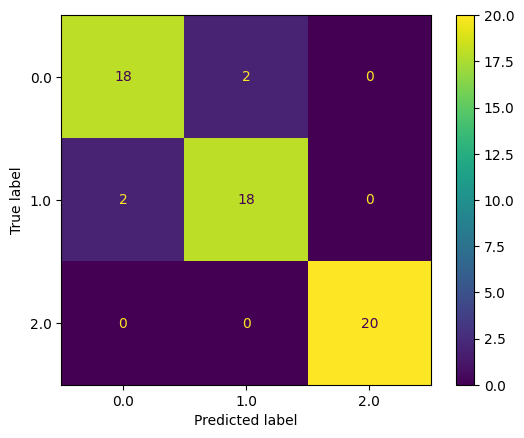

In [ ]:
#Evaluando casos mediante todos los clasificadores
Modelo_0 = KNeighborsClassifier(3)
Modelo_0.fit(X_train_normalized, Y_train)
Y_pred_0 =Modelo_0.predict (X_test_normalized)
print('Entrenamiento del modelo finalizado')
print(" ")

print('Mostrando métricas globales individuales: ')
print("Accuracy KNN",ACC(Y_test, Y_pred_0))
print("Precision KNN",PR(Y_test, Y_pred_0, average='macro'))
print("Recall KNN",RC(Y_test, Y_pred_0, average='macro'))
print("F1_Score KNN",F1(Y_test, Y_pred_0, average='macro'))
print(' ')

report = classification_report(Y_test, Y_pred_0)
print("Reporte de Clasificación:\n", report)
print(' ')

Matriz = CM(Y_test, Y_pred_0, labels = Modelo_0.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=Matriz,display_labels  =Modelo_0.classes_)
disp.plot()

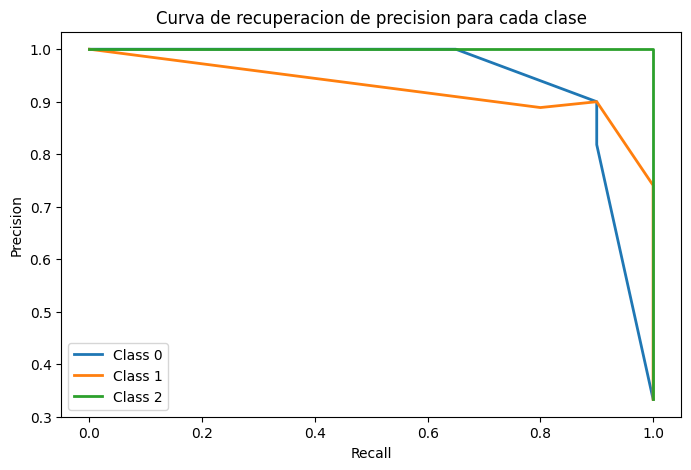

In [ ]:
# Obtener las probabilidades de predicción
Y_pred_prob = Modelo_0.predict_proba(X_test_normalized)

# Calcular las curvas de precisión y recall para cada clase
precision = dict()
recall = dict()
for i in range(len(Modelo_0.classes_)):
    precision[i], recall[i], _ = precision_recall_curve((Y_test == i).astype(int), Y_pred_prob[:, i])

# Graficar las curvas de precisión-recall para cada clase
plt.figure(figsize=(8, 5))
for i in range(len(Modelo_0.classes_)):
    plt.plot(recall[i], precision[i], lw=2, label='Class {}'.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de recuperacion de precision para cada clase')
plt.legend()
plt.show()

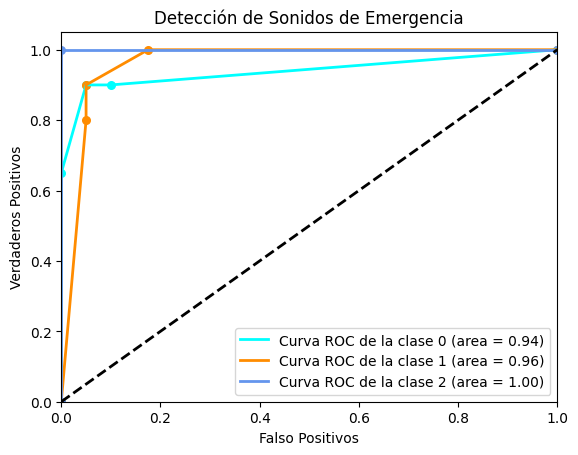

In [ ]:
# Binarizamos las etiquetas
Y_train_binarized = label_binarize(Y_train, classes=np.unique(Y))
Y_test_binarized = label_binarize(Y_test, classes=np.unique(Y))
n_classes = Y_train_binarized.shape[1]

# Entrenamos el clasificador en un enfoque de OneVsRest
modelo = OneVsRestClassifier(KNeighborsClassifier(3))
modelo.fit(X_train_normalized, Y_train_binarized)
Y_score = modelo.predict_proba(X_test_normalized)

# Calculamos la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Y por ultimo todas las curvas ROC
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curva ROC de la clase {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.scatter(fpr[i], tpr[i], color=color, s=30)  # Agregar puntos en los quiebres

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Detección de Sonidos de Emergencia')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import joblib
# Guardar el modelo entrenado en un archivo
drive_path = '/content/drive/MyDrive/'
filename = drive_path + 'modelo_entrenado_Audio.pkl'
joblib.dump(Modelo_0, filename)

print("Modelo guardado correctamente como", filename)

Modelo guardado correctamente como /content/drive/MyDrive/modelo_entrenado_Audio.pkl


# poner a prueba el modelo:

In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
import joblib

# Función que se utiliza para extraer caracteristicas de un archivo de audio
def extract_features(audio_file, muestreo=100000):
    señal, sr = librosa.load(audio_file, sr=None)
    señal_new = np.resize(señal, muestreo)

    # Extraemos las caracteristicas
    varianza = np.var(señal_new)
    desviacion = np.std(señal_new)
    rms_amplitude = np.sqrt(np.mean(np.square(señal_new)))
    zero_crossings = np.where(np.diff(np.sign(señal_new)))[0]
    zcr = len(zero_crossings)
    skewness = skew(señal_new)

    # Nuevos descriptores
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=señal_new, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=señal_new, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=señal_new, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=señal_new, sr=sr))
    mfccs = np.mean(librosa.feature.mfcc(y=señal_new, sr=sr), axis=1)[0]  # Solo el primer coeficiente MFCC

    return [varianza, desviacion, rms_amplitude, zcr, skewness, spectral_centroid, spectral_bandwidth,
            spectral_contrast, spectral_rolloff, mfccs]

# Cargamops el modelo entrenado
modelo_entrenado = joblib.load('/content/drive/MyDrive/modelo_entrenado_Audio.pkl')
nombre_archivo = '/content/drive/MyDrive/sound_284.wav'

# Extraemos las caracteristicas del archivo
nuevas_caracteristicas = extract_features(nombre_archivo)

# Paso 1: Ajustamos el StandardScaler con los datos de entrenamiento
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
# Paso 2: Transformar las nuevas caracteristicas utilizando el StandardScaler ajustado
nuevas_caracteristicas_normalized = scaler.transform(np.array([nuevas_caracteristicas]))


# Predecimos la clase del archivo
prediccion = modelo_entrenado.predict(nuevas_caracteristicas_normalized)

# Mapeamos la prediccion a las etiquetas originales
clases = {0: 'ambulance', 1: 'firetruck', 2: 'traffic'}
etiqueta_predicha = clases[prediccion[0]]

print("Clase predicha:", prediccion[0])
print("Etiqueta predicha:", etiqueta_predicha)


Clase predicha: 1.0
Etiqueta predicha: firetruck


# Simulacion Talanquera

In [ ]:

# extraemos caracteristicas de un archivo
def extract_features(audio_file, muestreo=100000):
    señal, sr = librosa.load(audio_file, sr=None)
    señal_new = np.resize(señal, muestreo)

    varianza = np.var(señal_new)
    desviacion = np.std(señal_new)
    rms_amplitude = np.sqrt(np.mean(np.square(señal_new)))
    zero_crossings = np.where(np.diff(np.sign(señal_new)))[0]
    zcr = len(zero_crossings)
    skewness = skew(señal_new)

    # Nuevos descriptores
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=señal_new, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=señal_new, sr=sr))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=señal_new, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=señal_new, sr=sr))
    mfccs = np.mean(librosa.feature.mfcc(y=señal_new, sr=sr), axis=1)[0]  # Solo el primer coeficiente MFCC

    return [varianza, desviacion, rms_amplitude, zcr, skewness, spectral_centroid, spectral_bandwidth,
            spectral_contrast, spectral_rolloff, mfccs]


modelo_entrenado = joblib.load('/content/drive/MyDrive/modelo_entrenado_Audio.pkl')

# Simulación de la talanquera
def simular_talanquera(estado):
    if estado == 'abajo':
        print("La talanquera está bajada.")
    elif estado == 'arriba':
        print("La talanquera se ha elevado.")

# Funcion para predecir si es un sonido de emergencia
def predecir_sonido(modelo, caracteristicas):
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    # Transformamos las nuevas caracteristicas utilizando el StandardScaler ajustado
    caracteristicas_normalized = scaler.transform(np.array([caracteristicas]))
    # Predecimos la clase del archivo de audio
    prediccion = modelo.predict(caracteristicas_normalized)
    return prediccion[0]

nombre_archivo = '/content/drive/MyDrive/sound_6.wav'
nuevas_caracteristicas = extract_features(nombre_archivo)

# Realizar la predicción
prediccion = predecir_sonido(modelo_entrenado, nuevas_caracteristicas)

# Mapear la predicción a las etiquetas originales
clases = {0: 'ambulance', 1: 'firetruck', 2: 'traffic'}
etiqueta_predicha = clases[prediccion]

print("Clase predicha:", prediccion)
print("Etiqueta predicha:", etiqueta_predicha)

# Ciclo que sirve para hacer simulacion de la talanquera
estado_talanquera = 'abajo'
while True:
    if prediccion in [0, 1]:  # Si la predicción es ambulancia o camión de bomberos
        simular_talanquera('arriba')  # Eleva la talanquera
        # Esperar un tiempo antes de volver a bajar la talanquera
        time.sleep(10)
        simular_talanquera('abajo')  # Baja la talanquera despues de un tiempo
        break
    else:
        print("No se detectó sonido de carro de emergencia.")
        break


Clase predicha: 0.0
Etiqueta predicha: ambulance
La talanquera se ha elevado.
La talanquera está bajada.
